In [8]:
import os
import pandas as pd
import h5py
from tqdm import tqdm
import numpy as np
from toolz import valmap
from scipy.spatial.distance import cdist
from rat_moseq.organization import get_rat_h5s, get_mouse_h5s
from rat_moseq.size import downsample, resize_video, count_nonzero#, mask_mouse#, median_pose

In [9]:
rat_key = 'frames_v2'
rat_h5s = get_rat_h5s(check=True, key=rat_key)
rat_h5s = np.random.choice(rat_h5s, size=50)

In [10]:
mouse_h5s = get_mouse_h5s()
mouse_h5s = [h5 for h5 in mouse_h5s if 'saline' in str(h5)]

In [14]:
downsampled = {}

downsampled_path = '/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/analysis/downsampled_rat.h5'

if not os.path.exists(downsampled_path):
    for h5 in tqdm(rat_h5s):
        with h5py.File(downsampled_path, 'w') as f:
            frames = downsample(h5, dset=rat_key)
            name = h5.parents[1].name
            downsampled[name] = frames
            f[name] = frames
else:
    with h5py.File(downsampled_path, 'r') as f:
        for key in f.keys():
            downsampled[key] = f[key][()]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [13:25<00:00, 16.11s/it]


In [15]:
def median_pose(frames):
    return np.median(frames, axis=0)

def mask_mouse(frames, thresh=10):
    return frames*(frames>thresh)

In [29]:
mouse_poses = {}
mouse_nonzeros = {}
for mouse_h5 in tqdm(mouse_h5s, total=len(mouse_h5s)):
    with h5py.File(mouse_h5, 'r') as f:
        mouse_median_pose = np.median(mask_mouse(f['frames'][()]), axis=0)

        mouse_poses[mouse_h5] = mouse_median_pose
        mouse_nonzeros[mouse_h5] = count_nonzero(mouse_median_pose)

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [02:33<00:00,  6.40s/it]


In [30]:
mouse_counts = np.array(list(mouse_nonzeros.values()))

In [31]:
factors = np.linspace(.5, 1, 10)
gross_factors = {}
gross_median_poses = {}
gross_counts = {}
gross_mse = {}

for factor in tqdm(factors, total=len(factors)):
    resized_dict = {}
    for k in downsampled.keys():
        _frames = downsampled[k]
        try:
            resized_dict[k] = resize_video(_frames, factor)
        except Exception as e:
            print(k)
            print(e)
            continue
    
    gross_factors[factor] = resized_dict

    median_poses = valmap(median_pose, resized_dict)
    gross_median_poses[factor] = median_poses

    gross_nonzeros = valmap(count_nonzero, median_poses)
    counts = np.array(list(gross_nonzeros.values()))
    gross_counts[factor] = counts

    dist = cdist(mouse_counts[:, None], counts[:, None])
    gross_mse[factor] = dist.mean(axis=0).mean()

100%|██████████| 10/10 [26:28<00:00, 158.84s/it]


In [37]:
gross_mse = pd.DataFrame(
    {
        'factor': list(gross_mse.keys()),
        'mse': list(gross_mse.values())
    }
)

In [38]:
gross_mse.to_csv('/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/dataframes_paper/fig1/scaling_mse.csv')

## forgot to add

In [2]:
import pandas as pd

In [3]:
gross_mse = pd.read_csv('/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/dataframes_paper/fig1/scaling_mse.csv')

In [4]:
gross_mse

,Unnamed: 0,factor,mse
0,0,0.500000,404.436111
1,1,0.555556,357.125000
2,2,0.611111,295.813889
3,3,0.666667,224.245370
4,4,0.722222,176.393519
5,5,0.777778,160.393519
6,6,0.833333,180.825000
7,7,0.888889,245.239815
8,8,0.944444,310.889815
9,9,1.000000,418.889815


In [5]:
from rat_moseq.io import load_downsampled_rat

In [6]:
downsampled_path = '/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/analysis/downsampled_rat.h5'
# downsampled = load_downsampled_rat(downsampled_path)

In [18]:
resized_path = '/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/analysis/resized_rat.h5'

factor = gross_mse.iloc[gross_mse['mse'].idxmin()]['factor']

with h5py.File(resized_path, 'w') as f:
    for k in downsampled.keys():
        _frames = downsampled[k]
        f[k] = resize_video(_frames, factor)

In [22]:
import matplotlib.pyplot as plt

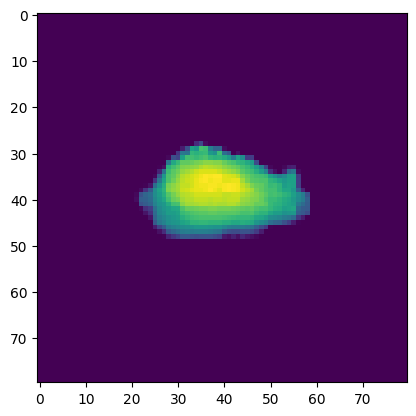

In [23]:
with h5py.File(resized_path, 'r') as f:
    plt.imshow(f['session_20240422113407'][()][0])